In [1]:
from __future__ import division
import os
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pycoingecko import CoinGeckoAPI

from catalyst.api import record, symbols, order_target_percent
from catalyst.utils.run_algo import run_algorithm

In [2]:
import pandas as pd
from ccxt_market_data import get_market_data, create_ETH_BTC, create_ETH_ETH
data_path = './data/'

list_currencies = ['ETH/BTC', 'ETH/USDT', 'KNC/ETH', 'BAT/ETH', 'MANA/ETH', 'ZRX/ETH',
                   'LINK/ETH', 'REP/ETH', 'RLC/ETH'
                  ]


for symbol in list_currencies:
    get_market_data(symbol=symbol, 
                    exchange_='binance', 
                    timeframe='1d', 
                    save=True, 
                    data_path=data_path)
    
create_ETH_BTC(data_path)
create_ETH_ETH(data_path)

In [4]:
def get_market_data_coingecko(symbol, _id):
    cg = CoinGeckoAPI()

    data = cg.get_coin_market_chart_by_id(_id, 'eth', 500)

    dates = [datetime.fromtimestamp(data['prices'][i][0] / 1000).strftime('%Y-%m-%d') for i in range(len(data['prices']))]
    price  = [data['prices'][i][1] for i in range(len(data['prices']))]

    df_data = {'Open': price, 'Timestamp' : dates} 
    df = pd.DataFrame(df_data)
    cols = ['Timestamp', 'Open']
    df = df[cols]
    
    df.drop(df.tail(1).index,inplace=True)

    df.to_csv(data_path + 'coingecko-{}-1d.csv'.format(symbol), index=False)
    
list_currencies = [['MKR_ETH', 'maker'],
                   ['ANT_ETH', 'aragon'],
                   ['MLN_ETH', 'melon'],
                   ['REN_ETH', 'republic-protocol']
                  ]

for currency in list_currencies:
    get_market_data_coingecko(currency[0], currency[1])

In [5]:
list_pairs_optim_binance = ['ETH_ETH', 'BTC_ETH', 'KNC_ETH',
                            'BAT_ETH', 'MANA_ETH', 'ZRX_ETH',  
                            'LINK_ETH', 'REP_ETH', 'RLC_ETH']

list_pairs_optim_coingecko = ['MKR_ETH', 'ANT_ETH', 
                              'MLN_ETH', 'REN_ETH'
                             ]

timeframe = '1d'

def create_portfolio(df, list_pairs: list, exchange: str, timeframe: str):
    '''
    This function is aimed to gather all pairs in a single dataframe. this is our portfolio
    '''
    for pair in list_pairs:
        filename = '{}-{}-{}.csv'.format(exchange, pair,timeframe)
        pair_data = pd.read_csv(data_path + filename)
        pair_data = pair_data.set_index('Timestamp')
        pair_data = pd.DataFrame(pair_data['Open']) 
        pair_data.columns = [pair]
        
        if pair == 'BTU_ETH':
            pair_data.loc['2019-08-12'] = 0.001644947
            pair_data = pair_data.sort_index()

        df = pd.concat([df, pair_data], axis=1)

    return df

df = pd.DataFrame()
df = create_portfolio(df, list_pairs=list_pairs_optim_binance,
                exchange='binance',
                timeframe=timeframe,
                )

df = create_portfolio(df, list_pairs=list_pairs_optim_coingecko,
                exchange='coingecko',
                timeframe=timeframe,
                )

df.to_csv(data_path + 'FullData.csv')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


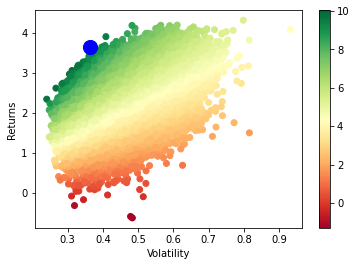

,44197
r,3.652886
stdev,0.364154
sharpe,10.031157
ETH_ETH,0.073695
BTC_ETH,0.032833
KNC_ETH,0.027334
BAT_ETH,0.072092
MANA_ETH,0.024954
ZRX_ETH,0.130882
LINK_ETH,0.004722


In [6]:
# Test Markowitz Optimization

# Set the time window that will be used to compute expected return and asset correlations
window = 28
# Set the number of days between each portfolio rebalancing
rebalance_period = 7
i = 0
nassets = len(list_pairs_optim_binance) + len(list_pairs_optim_coingecko)
df_balance = df


# Only rebalance at the beginning of the algorithm execution and
# every multiple of the rebalance period
if i == 0 or i % rebalance_period == 0:
    n = window
    prices = df_balance.fillna(method='ffill')
    # display(prices)
    pr = np.asmatrix(prices.values)
    t_prices = prices.iloc[1:n + 1]
    t_val = t_prices.values
    tminus_prices = prices.iloc[0:n]
    tminus_val = tminus_prices.values
    # Compute daily returns (r)
    r = np.asmatrix(t_val / tminus_val - 1)
    # Compute the expected returns of each asset with the average
    # daily return for the selected time window
    m = np.asmatrix(np.mean(r, axis=0))
    # ###
    stds = np.std(r, axis=0)
    # Compute excess returns matrix (xr)
    xr = r - m
    # Matrix algebra to get variance-covariance matrix
    cov_m = np.dot(np.transpose(xr), xr) / n
    # Compute asset correlation matrix (informative only)
    corr_m = cov_m / np.dot(np.transpose(stds), stds)

    # Define portfolio optimization parameters
    n_portfolios = 100000
    results_array = np.zeros((3 + nassets, n_portfolios))
    for p in range(n_portfolios):
        weights = np.random.random(nassets)
        weights /= np.sum(weights)
        w = np.asmatrix(weights)
        p_r = np.sum(np.dot(w, np.transpose(m))) * 365
        p_std = np.sqrt(np.dot(np.dot(w, cov_m),
                               np.transpose(w))) * np.sqrt(365)

        # store results in results array
        results_array[0, p] = p_r
        results_array[1, p] = p_std
        # store Sharpe Ratio (return / volatility) - risk free rate element
        # excluded for simplicity
        results_array[2, p] = results_array[0, p] / results_array[1, p]

        for i, w in enumerate(weights):
            results_array[3 + i, p] = w

    columns = ['r', 'stdev', 'sharpe'] + list_pairs_optim_binance + list_pairs_optim_coingecko
    
    # convert results array to Pandas DataFrame
    results_frame = pd.DataFrame(np.transpose(results_array),
                                 columns=columns)
    
    # locate position of portfolio with highest Sharpe Ratio
    max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
    # locate positon of portfolio with minimum standard deviation
    # min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]


    # create scatter plot coloured by Sharpe Ratio
    plt.scatter(results_frame.stdev,
                results_frame.r,
                c=results_frame.sharpe,
                cmap='RdYlGn')
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.colorbar()

    # plot blue circle to highlight position of portfolio
    # with highest Sharpe Ratio
    plt.scatter(max_sharpe_port[1],
                max_sharpe_port[0],
                marker='o',
                color='b',
                s=200)

    plt.show()
    display(pd.DataFrame(max_sharpe_port))

i += 1


In [9]:
print(corr_m.shape)

(39, 39)


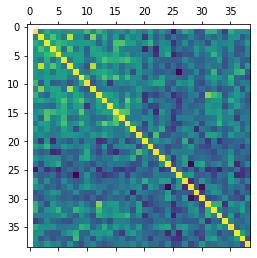

In [10]:
plt.matshow(corr_m)
plt.show()

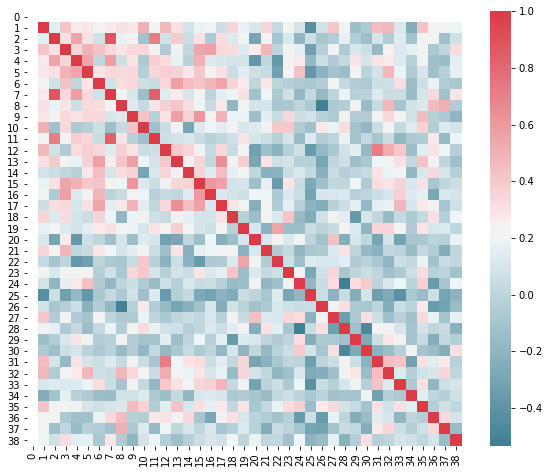

In [16]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_m, mask=np.zeros_like(corr_m, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [6]:
report = pd.DataFrame(max_sharpe_port)[3:]
report = round(100*report,2)
report

,4913
ETH_ETH,14.61
BTC_ETH,0.10
KNC_ETH,2.75
BAT_ETH,22.72
MANA_ETH,1.43
ZRX_ETH,0.72
LINK_ETH,1.23
REP_ETH,18.37
RLC_ETH,6.17
MKR_ETH,16.27
